# Pull political boundary data from OpenStreetMap as shapefile

This notebook pulls political boundary data from the OpenStreetMap database and creates a shapefile containing the query results.

#### Required packages

<a href="https://github.com/DinoTools/python-overpy">overpy</a> <br />
<a href="https://github.com/Toblerity/Fiona">Fiona</a>

#### Variable settings

bounding_box_filepath — path to shapefile to can define the desired bounding box to query the OpenStreetMap database <br />
result_shapefile_filepath — path to export shapefile containing the query results

In [1]:
bounding_box_file = ""

In [2]:
result_shapefile_filepath = ""

In [80]:
p1 = pyproj.Proj("+init=epsg:31254")
p2 = pyproj.Proj("+init=epsg:4326")
p3 = pyproj.Proj("+init=epsg:3857")
p4 = pyproj.Proj("+init=epsg:25832")

#### Import statements

In [90]:
import overpy
import fiona
import numpy
import geopandas
from shapely.ops import polygonize
from shapely.geometry import LineString

from database.models import Site
import pyproj

from matplotlib import pyplot
%matplotlib inline

#### Utility functions

function to see what results were returned from the Overpass API query

In [5]:
def print_results(results):
    for way in result.ways:
        print("Name: %s" % way.tags.get("name", "n/a"))
        print("  Highway: %s" % way.tags.get("highway", "n/a"))
        print("  Nodes:")
        for node in way.nodes:
            print("    Lat: %f, Lon: %f" % (node.lat, node.lon))

#### Query OpenStreetMap using OverpassAPI via overpy python package

setup Overpass api

In [3]:
api = overpy.Overpass()

define bounding box from a 1km-buffered envelope around the study area boundary

In [7]:
with fiona.open(bounding_box_file, mode='r') as bounding_box:
    bounds = bounding_box.bounds
    bounding_box.close()

In [8]:
print(bounds)

(11.290198256852443, 47.202364564149754, 11.470060257137265, 47.306229150962515)


define query 

In [9]:
query = """way({bottom},{left},{top},{right}) ["highway"]; (._;>;); out body;""".format(bottom=bounds[1],
                                                                                        left=bounds[0],
                                                                                        top=bounds[3],
                                                                                        right=bounds[2])

In [5]:
query = """
            [out:json];
            relation
            ["boundary"="administrative"]
            ["admin_level"="2"]
            ["name:en"="Austria"];
            (._;>;);
            out;
        """.replace("\n", "").replace(" ", "")

In [6]:
query

'[out:json];relation["boundary"="administrative"]["admin_level"="2"]["name:en"="Austria"];(._;>;);out;'

execute query

In [7]:
result = api.query(query)

In [8]:
ways = numpy.empty(len(result.ways), dtype=numpy.object)
for i, way in enumerate(result.ways):
    ways[i] = LineString([ (node.lon, node.lat) for node in way.nodes ])
boundaries = list(polygonize(ways))
boundaries = geopandas.GeoDataFrame(geometry=boundaries, crs="+init=epsg:4326")

In [9]:
boundaries

,geometry
0,"POLYGON ((16.1791723 46.9077653, 16.1790524 46..."
1,"POLYGON ((10.4723901 47.5869399, 10.4724211 47..."


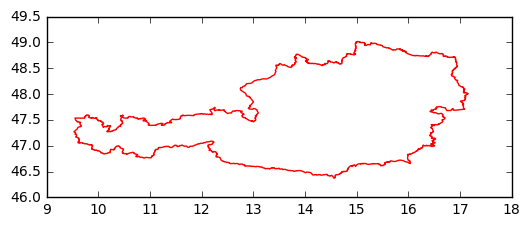

In [10]:
boundaries.plot(facecolor='white', edgecolor='red')

In [11]:
bbox = boundaries.bounds.iloc[0]

In [12]:
bbox

minx     9.530749
miny    46.372276
maxx    17.160776
maxy    49.020526
Name: 0, dtype: float64

In [13]:
query = """
            relation({s}, {w}, {n}, {e})
            ["boundary"="administrative"]
            ["admin_level"="2"];
            (._;>;);
            out;
        """.format(s=bbox['miny'], w=bbox['minx'], n=bbox['maxy'], e=bbox['maxx']).replace("\n", "").replace(" ", "")

In [14]:
query

'relation(46.3722761,9.5307487,49.0205264,17.160776)["boundary"="administrative"]["admin_level"="2"];(._;>;);out;'

In [15]:
result = api.query(query)

In [84]:
ways = numpy.empty(len(result.ways), dtype=numpy.object)
for i, way in enumerate(result.ways):
    ways[i] = LineString([ (node.lon, node.lat) for node in way.nodes ]).simplify(0.01, preserve_topology=False)
boundaries = list(polygonize(ways))
boundaries = geopandas.GeoDataFrame(geometry=boundaries, crs="+init=epsg:4326")
boundaries = boundaries.to_crs(crs="+init=epsg:25832")

In [64]:
center = Site.objects.get(name='Hofgarten')

In [85]:
x, y = center.geometry.coords
x, y = pyproj.transform(p1, p4, x, y)

In [82]:
x

681325.0483919675

In [83]:
y

5238280.111198772

In [97]:
geopandas.datasets.available

['naturalearth_cities', 'naturalearth_lowres']

In [112]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [113]:
area = world[world.name.isin(['Austria', 'Germany', 'Switzerland', 'Italy'])]

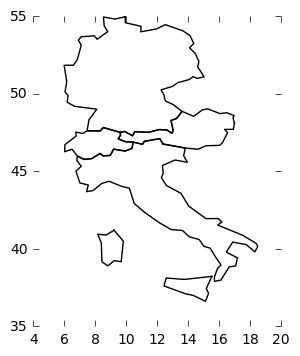

In [121]:
plt = area.plot(facecolor='white', edgecolor='black')
plt.set_frame_on(False)

#### Write OpenStreetMap data to a shapefile

In [11]:
from fiona.crs import from_epsg
schema = {'geometry': 'LineString', 'properties': {'Name':'str:80', 'Type':'str:80'}}
with fiona.open(result_shapefile_filepath, 'w', crs=from_epsg(4326), driver='ESRI Shapefile', schema=schema) as output:
    for way in result.ways:
        # the shapefile geometry use (lon,lat) 
        line = {'type': 'LineString', 'coordinates':[(node.lon, node.lat) for node in way.nodes]}
        prop = {'Name': way.tags.get("name", "n/a"), 'Type': way.tags.get("highway", "n/a")}
        output.write({'geometry': line, 'properties':prop})
    output.close()